## Example Images


## Setup

In [1]:
import pandas as pd
import numpy as np
import os
import config as cf
import tensorflow as tf
import rasterio
from rasterio import plot
from rasterio.plot import show
from skimage import exposure
import random

from matplotlib import pyplot as plt

/Users/robmarty/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
SURVEY_NAME = 'DHS'
SATELLITE = 's2'

## Funtions

In [3]:
#### RGB
def decode_fn_rgb(record_bytes):
    return tf.io.parse_single_example(
      # Data
      record_bytes,

      # Schema
      {"b_rgb": tf.io.FixedLenFeature([], tf.string)}
  )

def extract_rgb(TF_FILES):
    actual_values = []
    for batch in tf.data.TFRecordDataset([TF_FILES]).map(decode_fn_rgb):
        value = batch['b_rgb'].numpy()
        actual_values.append(value)

    return actual_values

#### NTL Group
def decode_fn_ntl_group(record_bytes):
    return tf.io.parse_single_example(
      # Data
      record_bytes,

      # Schema
      {"viirs_ntl_group": tf.io.FixedLenFeature([], dtype=tf.int64)}
  )

def extract_ntl_group(TF_FILES):
    actual_values = []
    for batch in tf.data.TFRecordDataset([TF_FILES]).map(decode_fn_ntl_group):
        value = batch['viirs_ntl_group'].numpy()
        actual_values.append(value)

    return actual_values

#### UID
def decode_fn_uid(record_bytes):
    return tf.io.parse_single_example(
      # Data
      record_bytes,

      # Schema
      {"uid": tf.io.FixedLenFeature([], dtype=tf.string)}
  )

def extract_uid(TF_FILES):
    actual_values = []
    for batch in tf.data.TFRecordDataset([TF_FILES]).map(decode_fn_uid):
        value = batch['uid'].numpy()
        actual_values.append(value)

    return actual_values

## Load Data

In [4]:
## Load Data
survey_df = pd.read_csv(os.path.join(cf.DROPBOX_DIRECTORY, 'Data', SURVEY_NAME, 'FinalData', 'Individual Datasets', 'data_for_cnn.csv'))

In [5]:
tf_record_list = list(np.unique(survey_df.tfrecord_name))

In [6]:
TF_DIR = os.path.join(cf.GOOGLEDRIVE_DIRECTORY, 
                      'Data', 
                      SURVEY_NAME, 
                      'FinalData',
                      'Individual Datasets',
                      'cnn_' + SATELLITE,
                      'tfrecords')

TF_FILES = os.listdir(TF_DIR)
TF_FILES = [os.path.join(TF_DIR, x) for x in TF_FILES]
TF_FILES = [string for string in TF_FILES if ".tfrecord" in string]

random.shuffle(TF_FILES)
len(TF_FILES)

88

## NTL Group

In [7]:
def prep_image_to_plot(img):

    img = img*0.0001
    p2, p98 = np.percentile(img, (2,98))
    img = exposure.rescale_intensity(img, in_range=(p2, p98)) # / 100000
    
    return img

def grab_example_image(tf_file, ntl_group_i):

    ## np array of ntl group
    ntl_group = extract_ntl_group(tf_file)
    ntl_group = np.asarray(ntl_group)

    ## ids of a group
    ntl_group_ids = np.where(ntl_group == ntl_group_i)
    ntl_group_ids = ntl_group_ids[0]

    ## randomly pick id
    np.random.shuffle(ntl_group_ids)
    id_i = ntl_group_ids[0]

    ## grab rgb data
    rgb_png = extract_rgb(tf_file)
    rgb_png_i = rgb_png[id_i]

    ## decode
    rgb_np_tensor = tf.io.decode_png(rgb_png_i, dtype=tf.dtypes.uint16)
    rgb_np = rgb_np_tensor.numpy()
    
    ## prep for plotting
    rgb_np = prep_image_to_plot(rgb_np)
    
    return rgb_np

## Example Image

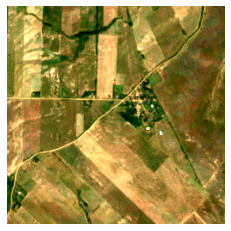

In [8]:
# One Example
ex_img = grab_example_image(TF_FILES[0], 0)

plt.imshow(ex_img)
plt.axis('off')
plt.show()

## Figure - All Groups

In [17]:
## Grab images
# IF NO GROUP IN TF_FILE, THEN WILL THROW AND ERROR; THEN CHANGE THE INDEX OF TF_FILE. WRITE CODE TO DO THIS.
im_ntl0_1 = grab_example_image(TF_FILES[0], 0)
im_ntl0_2 = grab_example_image(TF_FILES[1], 0)
im_ntl0_3 = grab_example_image(TF_FILES[2], 0)
im_ntl0_4 = grab_example_image(TF_FILES[3], 0)
im_ntl0_5 = grab_example_image(TF_FILES[4], 0)

im_ntl1_1 = grab_example_image(TF_FILES[5], 1)
im_ntl1_2 = grab_example_image(TF_FILES[6], 1)
im_ntl1_3 = grab_example_image(TF_FILES[7], 1)
im_ntl1_4 = grab_example_image(TF_FILES[8], 1)
im_ntl1_5 = grab_example_image(TF_FILES[9], 1)

im_ntl2_1 = grab_example_image(TF_FILES[15], 2)
im_ntl2_2 = grab_example_image(TF_FILES[11], 2)
im_ntl2_3 = grab_example_image(TF_FILES[16], 2)
im_ntl2_4 = grab_example_image(TF_FILES[19], 2)
im_ntl2_5 = grab_example_image(TF_FILES[14], 2)

(-0.5, 249.5, 249.5, -0.5)

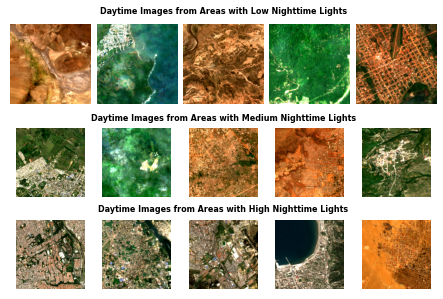

In [20]:
## Make Figure
SUBTITLE_FONT_SIZE = 8

fig = plt.figure(constrained_layout=True)
fig.suptitle('Daytime Images from Areas with Low Nighttime Lights', fontsize=SUBTITLE_FONT_SIZE, fontweight="bold")           

(subfig1, subfig2, subfig3) = fig.subfigures(3, 1) 
(ax1_1, ax1_2, ax1_3, ax1_4, ax1_5) = subfig1.subplots(1, 5)      
(ax2_1, ax2_2, ax2_3, ax2_4, ax2_5) = subfig2.subplots(1, 5)      
(ax3_1, ax3_2, ax3_3, ax3_4, ax3_5) = subfig3.subplots(1, 5)      

#subfig1.suptitle('Low Nighttime Lights')              

ax1_1.imshow(im_ntl0_1)
ax1_1.axis('off')

ax1_2.imshow(im_ntl0_2)
ax1_2.axis('off')

ax1_3.imshow(im_ntl0_3)
ax1_3.axis('off')

ax1_4.imshow(im_ntl0_4)
ax1_4.axis('off')

ax1_5.imshow(im_ntl0_5)
ax1_5.axis('off')

subfig2.suptitle('Daytime Images from Areas with Medium Nighttime Lights', fontsize=SUBTITLE_FONT_SIZE, fontweight="bold")              

ax2_1.imshow(im_ntl1_1)
ax2_1.axis('off')

ax2_2.imshow(im_ntl1_2)
ax2_2.axis('off')

ax2_3.imshow(im_ntl1_3)
ax2_3.axis('off')

ax2_4.imshow(im_ntl1_4)
ax2_4.axis('off')

ax2_5.imshow(im_ntl1_5)
ax2_5.axis('off')

subfig3.suptitle('Daytime Images from Areas with High Nighttime Lights', fontsize=SUBTITLE_FONT_SIZE, fontweight="bold")              

ax3_1.imshow(im_ntl2_1)
ax3_1.axis('off')

ax3_2.imshow(im_ntl2_2)
ax3_2.axis('off')

ax3_3.imshow(im_ntl2_3)
ax3_3.axis('off')

ax3_4.imshow(im_ntl2_4)
ax3_4.axis('off')

ax3_5.imshow(im_ntl2_5)
ax3_5.axis('off')

In [21]:
fig.savefig(os.path.join(cf.OVERLEAF_DIRECTORY, "figures", "example_daytime_images.png"), 
            dpi = 300,
            bbox_inches = "tight")